# Training the Model

In this notebook, we will use the engineered features to train a machine learning model to predict departure delays.

In [ ]:
# Executing this cell does some magic
%load_ext autoreload
%autoreload 2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab\ Notebooks/FlightDelay

/content/drive/MyDrive/Colab Notebooks/FlightDelay


In [ ]:
cd ..

d:\OneDrive\Personal_Things\My Website\My website HTML\backend\supplychainAPI


In [4]:
%%capture
!pip install -r requirements.txt

In [5]:
import pandas as pd
from models.src.LightGBM import LightGBM
from features.src.feature_engineering_depDelay import FeatureEngineeringDepDelay
from openmeteo_api.src.openmeteoapi.WeatherData import Weather
from openmeteo_api.src.openmeteoapi.APICaller import OpenMeteoAPICaller
from aeromarket_api.src.aeroapi_market.APICaller import APICaller
from aeromarket_api.src.aeroapi_market.Flights import Flights
from FlightWeather.src.FlightWeather import FlightWeather
from models.src.catboost import CatBoost
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from models.src.XGBoast import XGBoost
from models.src.RandomForest import RandomForest
from dotenv import load_dotenv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score


In [ ]:
sample_df = pd.read_parquet('./data/sample_df_v3.parquet')

## Handeling Missing Data

Before we train any model, it is a good idea to handle missing data earlier so we do not have bias in our prediction. Dropping missing data blindly could introduce some bias in our data, so it would be a better idea to decide how we handle them earlier. Lets first graph the missing data of the target variables.

In [ ]:
rows = []
s = sample_df["DepDelayMinutes"]
rows.append({
    "column": "DepDelayMinutes",
    "source": "sample_df",
    "missing_count": int(s.isna().sum()),
    "missing_%": float(s.isna().mean() * 100),
    "total_rows": int(len(s)),
})

missing_summary = pd.DataFrame(rows).sort_values(["missing_%", "missing_count"], ascending=False).reset_index(drop=True)
display(missing_summary)

,column,source,missing_count,missing_%,total_rows
0,DepDelayMinutes,sample_df,4,0.004,100000


We can see here that only 0.004% of the target variable `DepDelayMinutes` is missing. We can also check which rows are missing this data to see if there is any pattern.

In [ ]:
missing_mask = sample_df["DepDelayMinutes"].isna()
n_missing = int(missing_mask.sum())
n_total = int(len(sample_df))
print(f"Missing DepDelayMinutes: {n_missing} / {n_total} ({(n_missing/n_total)*100:.4f}%)")

key_cols = [c for c in ["IATA_Code_Operating_Airline", "Origin", "Dest", "dep_date_local", "arr_datetime", "Distance", "CRSElapsedTime"] if c in sample_df.columns]
if n_missing > 0:
    display(sample_df.loc[missing_mask, key_cols + ["DepDelayMinutes"]].reset_index(drop=True))

Missing DepDelayMinutes: 4 / 100000 (0.0040%)


,IATA_Code_Operating_Airline,Origin,Dest,dep_date_local,arr_datetime,Distance,CRSElapsedTime,DepDelayMinutes
0,9E,LGA,GSO,2018-04-30 15:00:00,2018-04-30 17:00:00,461.0,113.0,NaN
1,9E,RDU,LGA,2018-04-22 17:00:00,2018-04-22 18:00:00,431.0,109.0,NaN
2,9E,JFK,RIC,2018-04-27 19:00:00,2018-04-27 21:00:00,288.0,103.0,NaN
3,9E,JFK,RIC,2018-01-26 14:00:00,2018-01-26 16:00:00,288.0,104.0,NaN


As we can see here, all the missing values come from flights operated by "9E" airline. Depending on the amount of missing data and the importance of the feature, we can decide to either drop these rows or impute them with some value. In this case, since the amount of missing data is very small, we can safely drop these rows without introducing significant bias in our model.

In [ ]:
sample_df = sample_df[~missing_mask].reset_index(drop=True)

## Preparing the Data

As a first step, we will load the sample data and apply the feature engineering pipeline to prepare the data for modeling, and split the data into training and test sets.

In [ ]:
engineered_df = FeatureEngineeringDepDelay(sample_df).engineer_features()

In [ ]:
engineered_df.head()

,IATA_Code_Operating_Airline,Distance,CRSElapsedTime,dep_snowfall,dep_rain,dep_precipitation,dep_wind_speed_10m,dep_wind_gusts_10m,dep_cloud_cover_low,dep_cloud_cover,...,abs_apparent_temperature_delta,humidity_delta,abs_humidity_delta,pressure_delta,abs_pressure_delta,cloud_cover_delta,abs_cloud_cover_delta,dep_gust_factor,arr_gust_factor,congestion_delta
0,AS,605.0,115.0,0.0,0.0,0.0,6.725354,7.920000,0.0,0.0,...,5.520615,2.279617,2.279617,1.000000,1.000000,0.0,0.0,1.177633,2.198523,11.0
1,UA,589.0,116.0,0.0,0.0,0.0,4.334974,12.599999,0.0,0.0,...,9.553886,41.920712,41.920712,5.800049,5.800049,-100.0,100.0,2.906591,2.796868,-66.0
2,UA,1222.0,176.0,0.0,0.0,0.0,13.708391,20.160000,0.0,56.0,...,0.033024,-44.060558,44.060558,-7.700012,7.700012,-40.0,40.0,1.470632,2.687936,6.0
3,ZW,632.0,140.0,0.0,0.0,0.0,12.964998,33.839996,43.0,51.0,...,2.528877,24.500969,24.500969,-10.800049,10.800049,-27.0,27.0,2.610104,1.778373,-73.0
4,OO,282.0,89.0,0.0,0.0,0.0,1.484318,16.199999,0.0,0.0,...,12.453232,-47.497303,47.497303,-0.400024,0.400024,0.0,0.0,10.914103,2.669635,-38.0


In [ ]:
target_col = "log1p_DepDelayMinutes"
X = engineered_df.drop(columns=[target_col])
y = engineered_df[target_col]

cat_cols = X.select_dtypes(include=["object"]).columns.to_list()

for c in cat_cols:
  X[c] = X[c].astype("category")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 79996
Testing samples: 20000


## Linear Regression

As a baseline, we will first train a linear regression model. This will help us understand how well a simple model performs on this task.

In [ ]:
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns
num_cols = X_train.select_dtypes(exclude=["object", "category"]).columns
print(f"Categorical columns: {cat_cols.tolist()}")

Categorical columns: ['IATA_Code_Operating_Airline', 'route']


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("lr", LinearRegression())
])

In [ ]:
%%capture
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = mse_lr**0.5
r2_lr = r2_score(y_test, y_pred)

print("LR RMSE:", rmse_lr)
print("LR R²:", r2_lr)

LR RMSE: 1.447590790367504
LR R²: 0.10423253009445532


These results basically say the linear regression baseline isn’t doing much yet.

- **MSE: ~2.09** is the average squared error on our target. Note: our target is `log1p_DepDelayMinutes`, so this MSE is on the *log1p(minutes)* scale (not minutes).
- A more intuitive version is **RMSE**: $\sqrt{2.09} \approx 1.45$ (still on the log1p scale).
- **$R^2: ~0.09$** means the model only explains about **9% of the variance** in the test set. In other words: it’s only slightly better than predicting a constant delay for every flight.

So: this is a solid “baseline check”, but it’s a sign we’ll probably need a more flexible model (like LightGBM) to capture the non-linear patterns in delays.

## LightGBM

Now that we’ve got a baseline with linear regression, we can switch to **LightGBM**.

LightGBM is a gradient-boosted decision tree model (basically: lots of small trees added together, where each new tree tries to fix the mistakes from the previous ones). The nice part for this problem is that it can pick up **non‑linear relationships** and **feature interactions** that a simple linear model will usually miss.

So the goal here isn’t to “perfectly tune” it yet — it’s to see if a stronger model can capture more signal in the engineered features and improve our metrics.

In our LightGBM class, we have set up the model with some basic parameters. We will train the model on the training set and evaluate it on the test set.

In [ ]:
lgm_custom = LightGBM()
cat_cols = X_train.select_dtypes(include=["object"]).columns.to_list()
for c in cat_cols:
    X_train[c] = X_train[c].astype("category")

lgm_custom.fit(X_train, y_train, cat_cols=cat_cols, nfold=10, eval_train_metric=True)

[INFO] LightGBM - LightGBM model initialized with parameters: {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.05, 'num_leaves': 31, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'seed': 42, 'boosting_type': 'gbdt', 'verbose': -1, 'max_depth': -1, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'min_data_in_leaf': 20}
[INFO] LightGBM - Starting model training...


Training until validation scores don't improve for 20 rounds
[50]	train's rmse: 1.4092 + 0.000964394	valid's rmse: 1.42992 + 0.00829368
[100]	train's rmse: 1.37794 + 0.000965766	valid's rmse: 1.41863 + 0.00862381
[150]	train's rmse: 1.35657 + 0.00110601	valid's rmse: 1.41551 + 0.00914164
[200]	train's rmse: 1.33872 + 0.00128133	valid's rmse: 1.41422 + 0.00913825
[250]	train's rmse: 1.32256 + 0.00123971	valid's rmse: 1.41379 + 0.0093588
[300]	train's rmse: 1.30744 + 0.00114341	valid's rmse: 1.41333 + 0.00960345


[INFO] LightGBM - Best iteration from CV: 304


Early stopping, best iteration is:
[304]	train's rmse: 1.30632 + 0.00112015	valid's rmse: 1.41326 + 0.00961865


[INFO] LightGBM - Model training completed.


In [ ]:
y_pred = lgm_custom.predict(X_test)

In [ ]:
mse_lgbm = mean_squared_error(y_test, y_pred)
rmse_lgbm = mse_lgbm**0.5
r2_lgbm = r2_score(y_test, y_pred)

print("LightGBM RMSE:", rmse_lgbm)
print("LightGBM R²:", r2_lgbm)

LightGBM RMSE: 1.4135615655958562
LightGBM R²: 0.14585201528508407


These results show LightGBM is **clearly learning more signal** than our linear regression baseline.

- **RMSE: 1.414** on `log1p_DepDelayMinutes` (so the error is on the *log1p(minutes)* scale, not raw minutes).
- **$R^2: 0.146$** means the model explains about **14.6% of the variance** in the test set.

Compared to the baseline linear regression (RMSE ~$1.45$, $R^2$ ~$0.09$), LightGBM is an improvement: **lower error and higher explained variance**. That’s what we’d expect from boosted trees, since they can capture **non-linear effects** (e.g., weather impacts, airport/route effects, schedule interactions) and **feature interactions** that a linear model can’t.

## XGBoost

Now, we will train an XGBoost model using the same training and test sets. XGBoost is another powerful gradient-boosted decision tree model that often performs well on structured data tasks like this one.

In [ ]:
xgbm = XGBoost(use_gpu=False, enable_categorical=True, max_depth=10, learning_rate=0.01)
xgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    num_boost_round=2000,
    early_stopping_rounds=200,
    verbose_eval=False,
 )

y_pred_xgb = xgbm.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost RMSE:", rmse_xgb)
print("XGBoost R²:", r2_xgb)

[INFO] XGBoost - XGBoost initialized with parameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 'seed': 42, 'nthread': -1, 'tree_method': 'hist'}
[INFO] XGBoost - Starting XGBoost training...


We are here


[INFO] XGBoost - Training completed.


XGBoost RMSE: 1.477385917645829
XGBoost R²: 0.06697866641760086


These results basically say the XGBoost model **isn’t beating our baseline yet**.

- **RMSE: ~1.47** on `log1p_DepDelayMinutes` (so this is still on the *log1p(minutes)* scale, not raw minutes).
- **$R^2: ~0.066$** means it explains about **6–7% of the variance** in the test set.

So even though XGBoost *can* be a strong model for tabular data, right now it’s not finding much extra signal beyond what we already had (and it’s actually a bit worse than the linear regression baseline).

## Random Forest

Finally, we will train a Random Forest model using the same training and test sets. Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mean prediction of the individual trees.

In [ ]:
rf = RandomForest(
    n_trees=200,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=8,
    seed=42,
 )

rf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose_eval=False)
y_pred_rf_like = rf.predict(X_test)

mse_rf_like = mean_squared_error(y_test, y_pred_rf_like)
rmse_rf_like = mse_rf_like ** 0.5
r2_rf_like = r2_score(y_test, y_pred_rf_like)

print("XGB-RF RMSE:", rmse_rf_like)
print("XGB-RF R²:", r2_rf_like)

[INFO] RandomForest - RandomForest (XGB-RF) initialized with parameters: {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 1.0, 'num_parallel_tree': 200, 'subsample': 0.8, 'colsample_bytree': 0.8, 'max_depth': 8, 'seed': 42, 'nthread': -1, 'tree_method': 'hist'}
[INFO] RandomForest - Starting RandomForest (XGB-RF) training...
[INFO] RandomForest - Training completed.


XGB-RF RMSE: 1.4801058119091801
XGB-RF R²: 0.06354008569722558


There results show that Random Forest is not performing any better than XGBoost or even Linear Regression.

## CatBoost

Finally, we will train a CatBoost model using the same training and test sets. CatBoost is another gradient-boosted decision tree model that is particularly good at handling categorical features. It is very similar to LightGBM and XGBoost in terms of functionality, but it has some unique features that make it stand out, such as its ability to handle categorical features natively without the need for one-hot encoding.

In [ ]:
# CatBoost


cb = CatBoost(
    use_gpu=False,
    iterations=5000,
    learning_rate=0.05,
    depth=8,
    random_seed=42,
    verbose=False,
 )

cb.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100)
y_pred_cb = cb.predict(X_test)

mse_cb = mean_squared_error(y_test, y_pred_cb)
rmse_cb = mse_cb ** 0.5
r2_cb = r2_score(y_test, y_pred_cb)

print("CatBoost RMSE:", rmse_cb)
print("CatBoost R²:", r2_cb)

[INFO] CatBoost - CatBoost initialized with parameters: {'loss_function': 'RMSE', 'eval_metric': 'RMSE', 'random_seed': 42, 'verbose': False, 'iterations': 5000, 'learning_rate': 0.05, 'depth': 8}
[INFO] CatBoost - Starting CatBoost training...
[INFO] CatBoost - Training completed.


CatBoost RMSE: 1.3976383434774091
CatBoost R²: 0.16498692191196362


In [ ]:
RMSES = {
    "Linear Regression": rmse_lr,
    "LightGBM": rmse_lgbm,
    "XGBoost": rmse_xgb,
    "CatBoost": rmse_cb,
    "XGB-RF": rmse_rf_like,
}
R2S = {
    "Linear Regression": r2_lr,
    "LightGBM": r2_lgbm,
    "XGBoost": r2_xgb,
    "CatBoost": r2_cb,
    "XGB-RF": r2_rf_like,
}
results_df = pd.DataFrame({
    "Model": RMSES.keys(),
    "RMSE": RMSES.values(),
    "R²": R2S.values(),
}).sort_values(by="RMSE").reset_index(drop=True)
display(results_df)

,Model,RMSE,R²
0,CatBoost,1.397638,0.164987
1,LightGBM,1.413562,0.145852
2,Linear Regression,1.447591,0.104233
3,XGBoost,1.477386,0.066979
4,XGB-RF,1.480106,0.063540


Given the results, CatBoost is performing the best. However, it is still not performing significantly better than LightGBM. We are expecting to use LightGBM given its faster training time compared to CatBoost in our actual deployment scenario.

## Classification

The regression models were stable and generally good, but they plateaued at relatively low R² values (≈ 0.10–0.16), even with non-linear tree-based methods. This suggests that while there is predictive signal in the data, the exact magnitude of departure delay is noisy and partially driven by unobserved operational factors.

To better align the modeling objective with the available signal, I will reframe the problem as a binary classification task: predicting whether a flight will experience a meaningful departure delay. This formulation reduces sensitivity to extreme outliers and focuses the model on learning stable delay patterns rather than precise delay values.

In [ ]:
dd = sample_df["DepDelayMinutes"]

bins = [-float("inf"), 14, 45, float("inf")]
labels = [ "1–14", "15–45", ">45"]
display(pd.cut(dd, bins=bins, labels=labels).value_counts().sort_index())

DepDelayMinutes
1–14     82714
15–45     9495
>45       7787
Name: count, dtype: int64

In [ ]:
train_cls_sample, test_cls_sample = train_test_split(
    sample_df, test_size=0.2, random_state=42, shuffle=True
 )

In [ ]:
engineered_df_class_train_sample = FeatureEngineeringDepDelay(train_cls_sample, classification=True).engineer_features()
engineered_df_class_test_sample = FeatureEngineeringDepDelay(test_cls_sample, classification=True, type="new").engineer_features(is_test=True)

target_col = "DepDelayCategory"

X_train_cls = engineered_df_class_train_sample.drop(columns=[target_col])
y_train_cls = engineered_df_class_train_sample[target_col].astype(int)

X_test_cls = engineered_df_class_test_sample.drop(columns=[target_col])
y_test_cls = engineered_df_class_test_sample[target_col].astype(int)
cat_cols = X_train_cls.select_dtypes(include=["object"]).columns.to_list()
for c in cat_cols:
    X_train_cls[c] = X_train_cls[c].astype("category")
    X_test_cls[c] = X_test_cls[c].astype("category")


In [ ]:
engineered_df_class_train_sample.groupby('DepDelayCategory').size()

DepDelayCategory
0    75238
1     4758
dtype: int64

## LightGBM Classification

Our LightGBM Regression model showed promising results, so we will adapt it for classification. We will define meaningful delay categories and train the model to predict these classes.

In [ ]:
lgbm_cls = LightGBM(
    classification=True,
    objective="multiclass",
    metric="multi_logloss",
    num_class=3,
 )

lgbm_cls.fit(X_train_cls, y_train_cls, cat_cols=cat_cols, nfold=10, eval_train_metric=True)
y_pred_cls = lgbm_cls.predict(X_test_cls)

print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred_cls))
print(classification_report(y_test_cls, y_pred_cls))

[INFO] LightGBM - LightGBM model initialized with parameters: {'objective': 'multiclass', 'metric': 'multi_logloss', 'learning_rate': 0.05, 'num_leaves': 31, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'seed': 42, 'boosting_type': 'gbdt', 'verbose': -1, 'max_depth': -1, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'min_data_in_leaf': 20, 'num_class': 3}
[INFO] LightGBM - Starting model training...


Training until validation scores don't improve for 20 rounds


[INFO] LightGBM - Best iteration from CV: 27


Early stopping, best iteration is:
[27]	train's multi_logloss: 0.17523 + 0.000309315	valid's multi_logloss: 0.198068 + 0.00241909


[INFO] LightGBM - Model training completed.


Accuracy: 0.9422
Confusion matrix:
 [[18834     0]
 [ 1156    10]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     18834
           1       1.00      0.01      0.02      1166

    accuracy                           0.94     20000
   macro avg       0.97      0.50      0.49     20000
weighted avg       0.95      0.94      0.91     20000



### LightGBM (Multiclass) — Results

**Overall**
- **Accuracy:** `0.83415`
- **Test set size:** `20000`

**Class 0 vs Rest**
```text
                 Pred +      Pred -
Actual + (class 0)   TP=16647    FN=8
Actual - (not 0)     FP=3306     TN=39
```

**Class 1 vs Rest**
```text
                 Pred +      Pred -
Actual + (class 1)   TP=27       FN=2152
Actual - (not 1)     FP=7        TN=17814
```

**Class 2 vs Rest**
```text
                 Pred +      Pred -
Actual + (class 2)   TP=9        FN=1157
Actual - (not 2)     FP=4        TN=18830
```


**Notes**
- The model performs very well on **Class 0** (recall ≈ `1.00`).
- **Classes 1 and 2** have very low recall (≈ `0.01`), meaning the model rarely predicts these classes.

This is a known Problem in ML called Class Imbalance, where one class (here, Class 0) dominates the dataset, making it hard for the model to learn to predict the minority classes (Classes 1 and 2). To address this, we can try techniques like oversampling the minority classes, undersampling the majority class, or using class weights in the loss function to give more importance to the minority classes during training.

## Weighting Classes

The first step to address class imbalance is to weight the classes inversely proportional to their frequencies. This way, the model will pay more attention to the minority classes during training. Let's compute the class weights and retrain the LightGBM model with these weights.

In [ ]:
classes = np.unique(y_train_cls)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_cls
)

class_weight_dict = dict(zip(classes, class_weights))
class_weight_dict

{np.int64(0): np.float64(0.5309703969202177),
 np.int64(1): np.float64(8.572224603514789)}

Now let's class weight to sample weights.

In [ ]:
sample_weights = y_train_cls.map(class_weight_dict)

Now, we will retrain the LightGBM model using the computed class weights to see if it improves performance on the minority classes.

In [ ]:
rng = 42

params = {
    "objective": "binary",
    "metric": "average_precision",
    "learning_rate": 0.03,
    "num_leaves": 63,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.85,
    "bagging_fraction": 0.85,
    "bagging_freq": 1,
    "seed": 42,
    "verbose": -1,
}

lgbm_cls = LightGBM(
    classification=True,
    **params,
 )

lgbm_cls.fit(
    X_train_cls,
    y_train_cls,
    cat_cols=cat_cols,
    sample_weight=sample_weights,
    nfold=10,
    eval_train_metric=True,
 )
y_pred_cls = lgbm_cls.predict(X_test_cls)

print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred_cls))
print(classification_report(y_test_cls, y_pred_cls))

[INFO] LightGBM - LightGBM model initialized with parameters: {'objective': 'binary', 'metric': 'average_precision', 'learning_rate': 0.03, 'num_leaves': 63, 'feature_fraction': 0.85, 'bagging_fraction': 0.85, 'bagging_freq': 1, 'seed': 42, 'boosting_type': 'gbdt', 'verbose': -1, 'max_depth': -1, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'min_data_in_leaf': 50}
[INFO] LightGBM - Starting model training...


Training until validation scores don't improve for 20 rounds


[INFO] LightGBM - Best iteration from CV: 5


Early stopping, best iteration is:
[5]	train's average_precision: 0.819008 + 0.00644439	valid's average_precision: 0.687325 + 0.01508


[INFO] LightGBM - Model training completed.


Accuracy: 0.68725
Confusion matrix:
 [[13047  5787]
 [  468   698]]
              precision    recall  f1-score   support

           0       0.97      0.69      0.81     18834
           1       0.11      0.60      0.18      1166

    accuracy                           0.69     20000
   macro avg       0.54      0.65      0.49     20000
weighted avg       0.92      0.69      0.77     20000



Our goal of this model is to catch class 1. In this case, recall of class 1 is 0.58, which mean the model is able to identify 58% of the actual class 1 instances. Precision of 0.14 of class 1 means that when the model predicts class 1, it is correct 14% of the time and wrong 86% of the time. It is really not what we want yet, but it is a good improvement from before.

In [ ]:
conf = confusion_matrix(y_test_cls, y_pred_cls)

n_classes = int(conf.shape[0])
if n_classes == 2:
    class_labels = ["Not_Delayed", "Delayed"]
else:
    class_labels = [f"Class_{i}" for i in range(n_classes)]

conf_df = pd.DataFrame(
    conf,
    index=[f"Actual_{c}" for c in class_labels],
    columns=[f"Pred_{c}" for c in class_labels],
)

display(conf_df)

conf_df /conf.sum()

,Pred_Not_Delayed,Pred_Delayed
Actual_Not_Delayed,13179,5655
Actual_Delayed,498,668


,Pred_Not_Delayed,Pred_Delayed
Actual_Not_Delayed,0.65895,0.28275
Actual_Delayed,0.02490,0.03340


## CatBoost Classification

Now, we will retrain the CatBoost model using the computed class weights to see if it improves performance on the minority classes.

**Update**: Added Destination and Origin airport on-time rate features, and year features to help the model capture more patterns related to airport performance and temporal trends.

In [ ]:
engineered_df_class = FeatureEngineeringDepDelay(sample_df, classification=True).engineer_features()

target_col = "DepDelayCategory"

drop_cols = [c for c in [target_col, "log1p_DepDelayMinutes"] if c in engineered_df_class.columns]
X_cls = engineered_df_class.drop(columns=drop_cols)
y_cls = engineered_df_class[target_col].astype(int)

cat_cols = X_cls.select_dtypes(include=["object"]).columns.to_list()
for c in cat_cols:
    X_cls[c] = X_cls[c].astype("category")

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
 )

engineered_df_class.groupby('DepDelayCategory').size()

DepDelayCategory
0    94056
1     5940
dtype: int64

In [ ]:
params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 2000,
    "learning_rate": 0.03,
    "depth": 6,
    "l2_leaf_reg": 5,
    "subsample": 0.8,
    "auto_class_weights": "Balanced",
    "random_seed": 42,
    "verbose": False,
}


cb_cls = CatBoost(classification=True, **params)

cb_cls.fit(
    X_train_cls,
    y_train_cls,
    nfold=5,
    early_stopping_rounds=100)

y_pred = cb_cls.predict(X_test_cls)

print("Accuracy:", accuracy_score(y_test_cls, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred))
print(classification_report(y_test_cls, y_pred))

[INFO] CatBoost - CatBoost initialized with parameters: {'loss_function': 'Logloss', 'eval_metric': 'AUC', 'random_seed': 42, 'verbose': False, 'iterations': 2000, 'learning_rate': 0.03, 'depth': 6, 'l2_leaf_reg': 5, 'subsample': 0.8, 'auto_class_weights': 'Balanced'}
[INFO] CatBoost - Running 5-fold CV to select iterations...


Training on fold [0/5]

bestTest = 0.8105831911
bestIteration = 484

Training on fold [1/5]

bestTest = 0.8093700947
bestIteration = 499

Training on fold [2/5]

bestTest = 0.8033359782
bestIteration = 488

Training on fold [3/5]

bestTest = 0.8244015065
bestIteration = 464

Training on fold [4/5]


[INFO] CatBoost - Starting CatBoost training (CV-selected iterations)...



bestTest = 0.8143189112
bestIteration = 505



[INFO] CatBoost - Training completed.


Accuracy: 0.718
Confusion matrix:
 [[13470  5342]
 [  298   890]]
              precision    recall  f1-score   support

           0       0.98      0.72      0.83     18812
           1       0.14      0.75      0.24      1188

    accuracy                           0.72     20000
   macro avg       0.56      0.73      0.53     20000
weighted avg       0.93      0.72      0.79     20000



Note that in this model, we calculated the stats for all data, including training and test sets. This is data leakage and should not be done in practice. However, this gives us an idea of the best possible performance we can achieve with this model. Given that we will train on a huge dataset later, we expect the model to perform better.

In [ ]:
y_score = cb_cls.predict(X_test_cls, prediction_type='Probability')[:, 1]
y_score

array([0.4761003 , 0.59979521, 0.65275019, ..., 0.47542734, 0.40653235,
       0.46209699], shape=(20000,))

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test_cls, y_score)
auc = roc_auc_score(y_test_cls, y_score)

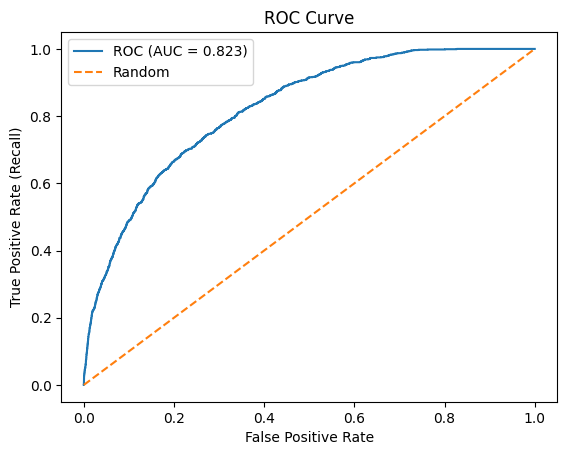

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

Now we want to increase the precision of class 1, at the price of recall. We can do this by adjusting the decision threshold.

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred_proba = cb_cls.predict(X_test_cls, prediction_type="Probability")
class_1_proba = y_pred_proba[:, 1]
y_test_binary = (y_test_cls == 1).astype(int)

for threshold in list(np.arange(0.4, 0.9, 0.02)):
    y_pred = (class_1_proba >= threshold).astype(int)
    precision = precision_score(y_test_binary, y_pred, zero_division=0)
    recall = recall_score(y_test_binary, y_pred, zero_division=0)
    f1 = f1_score(y_test_binary, y_pred, zero_division=0)
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Threshold: 0.40, Precision: 0.1107, Recall: 0.8729, F1: 0.1965
Threshold: 0.42, Precision: 0.1150, Recall: 0.8485, F1: 0.2026
Threshold: 0.44, Precision: 0.1188, Recall: 0.8190, F1: 0.2075
Threshold: 0.46, Precision: 0.1246, Recall: 0.7988, F1: 0.2156
Threshold: 0.48, Precision: 0.1329, Recall: 0.7803, F1: 0.2272
Threshold: 0.50, Precision: 0.1406, Recall: 0.7534, F1: 0.2370
Threshold: 0.52, Precision: 0.1484, Recall: 0.7231, F1: 0.2463
Threshold: 0.54, Precision: 0.1574, Recall: 0.6919, F1: 0.2564
Threshold: 0.56, Precision: 0.1712, Recall: 0.6667, F1: 0.2724
Threshold: 0.58, Precision: 0.1815, Recall: 0.6254, F1: 0.2814
Threshold: 0.60, Precision: 0.1972, Recall: 0.5850, F1: 0.2949
Threshold: 0.62, Precision: 0.2145, Recall: 0.5463, F1: 0.3080
Threshold: 0.64, Precision: 0.2267, Recall: 0.4891, F1: 0.3098
Threshold: 0.66, Precision: 0.2427, Recall: 0.4394, F1: 0.3127
Threshold: 0.68, Precision: 0.2638, Recall: 0.3931, F1: 0.3158
Threshold: 0.70, Precision: 0.2845, Recall: 0.3468, F1:

Now we can build our final model.

In [ ]:
import numpy as np

class DelayClassifier:
    def __init__(self, model, threshold=0.6):
        self.model = model
        self.threshold = threshold

    def predict_proba(self, X):
        return self.model.predict(X, prediction_type="Probability")[:, 1]

    def predict(self, X):
        return (self.predict_proba(X) >= self.threshold).astype(int)

delay_classifier = DelayClassifier(cb_cls, threshold=0.60)

y_pred_cls = delay_classifier.predict(X_test_cls)

print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred_cls))
print(classification_report(y_test_cls, y_pred_cls))

Accuracy: 0.83385
Confusion matrix:
 [[15982  2830]
 [  493   695]]
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     18812
           1       0.20      0.59      0.29      1188

    accuracy                           0.83     20000
   macro avg       0.58      0.72      0.60     20000
weighted avg       0.92      0.83      0.87     20000



Let say we want to predict a flight that going from Baltimore to Denver on January 12 (in 6 days). We will need to call the FlightWeather class wrapper in order to get the weather and flight data.

In [ ]:
flightWeather = FlightWeather(flight_num="UA 2012", flight_date="2026-01-12")

In [ ]:
flight_df = flightWeather.get_full_data()

Fetching weather data from: https://api.open-meteo.com/v1/forecast
Successfully fetched data for 2 airport(s).


In [ ]:
set(sample_df.drop(columns=["DepDelayMinutes", 'arr_date']).columns) == set(flight_df.columns)

True

In my feature engineering class, I save .pkl files for stats about airlines, airports, and routes. When I predict a new feature, I can set type = "new", and the files will be loaded and attached to the new flight. When I load these .pkl files, I make sure to handle any unknown categories by filling in missing values with statistics for an "__UNKNOWN__" category. This way, if the flight data includes an airline, airport, or route that wasn't seen during training, the model can still make a reasonable prediction using the average statistics for unknown categories.

In [ ]:
import pickle
with open('./data/route_stats.pkl', 'rb') as f:
    route_stats = pickle.load(f)

In [ ]:
flight_df_engineered = FeatureEngineeringDepDelay(flight_df, type="new").engineer_features()
flight_df_engineered

,IATA_Code_Operating_Airline,Distance,CRSElapsedTime,dep_snowfall,dep_rain,dep_precipitation,dep_wind_speed_10m,dep_wind_gusts_10m,dep_cloud_cover_low,dep_cloud_cover,dep_temperature_2m,dep_apparent_temperature,dep_surface_pressure,dep_relative_humidity_2m,dep_pressure_msl,arr_snowfall,arr_rain,arr_precipitation,arr_wind_speed_10m,arr_wind_gusts_10m,arr_cloud_cover_low,arr_cloud_cover,arr_temperature_2m,arr_apparent_temperature,arr_surface_pressure,arr_relative_humidity_2m,arr_pressure_msl,departure_hour,departure_day,departure_month,departure_weekday,departure_is_weekend,departure_is_peak_hour,arrival_hour,arrival_day,arrival_month,arrival_weekday,arrival_is_weekend,arrival_is_peak_hour,average_delay,delay_stddev,on_time_rate,is_high_dep_congestion,is_high_arr_congestion,dep_congestion_bucket,arr_congestion_bucket,route,average_route_delay,delay_route_stddev,dep_congestion_x_precipitation,dep_congestion_x_wind_gusts,dep_congestion_x_snowfall,arr_congestion_x_precipitation,arr_congestion_x_wind_gusts,arr_congestion_x_snowfall,distance_x_dep_precipitation,distance_x_dep_wind_gusts_10m,distance_x_dep_snowfall,distance_x_arr_precipitation,distance_x_arr_wind_gusts_10m,distance_x_arr_snowfall,temperature_delta,abs_temperature_delta,apparent_temperature_delta,abs_apparent_temperature_delta,humidity_delta,abs_humidity_delta,pressure_delta,abs_pressure_delta,cloud_cover_delta,abs_cloud_cover_delta,dep_gust_factor,arr_gust_factor,congestion_delta
0,UA,1491.0,220.0,0.0,0.0,0.0,16.055355,25.559999,0.0,2.0,5.111,-0.563633,1020.597168,30.0,1026.5,0.0,0.0,0.0,11.570515,16.559999,0.0,8.0,1.2005,-3.277061,839.25769,63.0,1024.199951,16,12,1,0,0,1,18,12,1,0,0,1,15.128977,55.574644,0.792409,0,1,1,3,BWI-DEN,12.081081,16.535111,0.0,638.999987,0.0,0.0,1838.159941,0.0,0.0,38109.959204,0.0,0.0,24690.959204,0.0,3.9105,3.9105,2.713428,2.713428,-33.0,33.0,2.300049,2.300049,-6.0,6.0,1.591992,1.431224,-86


In [ ]:
route_stats.loc['BWI-DEN']

average_route_delay    12.081081
delay_route_stddev     16.535111
Name: BWI-DEN, dtype: float64

In [ ]:
BTW_DEN_pred = cb_cls.predict(flight_df_engineered, prediction_type="Probability")

In [ ]:
BTW_DEN_pred

array([[0.65752067, 0.34247933]])

Based On this results, the model predicted that the flight has a 75% chance of being in class 0 (on time), a 20% chance of being in class 1 (60 minutes delayed). Is not that amazing?

We can now save the model for future use.

In [ ]:
with open('./data/catboost_sample_model.pkl', 'wb') as f:
    pickle.dump(cb_cls, f)

Then Use it again later by loading it from the .pkl file.

In [ ]:
with open('./data/catboost_sample_model.pkl', 'rb') as f:
    cb_loaded = pickle.load(f)
cb_loaded.predict(flight_df_engineered, prediction_type="Probability")

array([[0.74138222, 0.25861778]])

## Training on GPUs

We already trained the LightGBM and CatBoost models on CPU, and we showed that CatBoost performed slightly better than LightGBM for our classification task. However, our model got low precision for class 1, which means that out of all delayed flights predicted by the model, only a small fraction were actually delayed. This is not ideal for our use case, as we want to minimize false positives (i.e., predicting a flight will be delayed when it is not). Maybe a better solution would be to train the model on GPUs, which can handle larger datasets and more complex models more efficiently than CPUs. By leveraging the parallel processing capabilities of GPUs, we can potentially improve the model's performance and achieve better precision for class 1.

In [ ]:
full_df = pd.read_parquet('./data/full_df_v3.parquet')

## Handeling Missing Data

Before we train any model, it is a good idea to handle missing data earlier so we do not have bias in our prediction. Dropping missing data blindly could introduce some bias in our data, so it would be a better idea to decide how we handle them earlier. Lets first graph the missing data of the target variables.

In [ ]:
rows = []
s = full_df["DepDelayMinutes"]
rows.append({
    "column": "DepDelayMinutes",
    "source": "full_df",
    "missing_count": int(s.isna().sum()),
    "missing_%": float(s.isna().mean() * 100),
    "total_rows": int(len(s)),
})

missing_summary = pd.DataFrame(rows).sort_values(["missing_%", "missing_count"], ascending=False).reset_index(drop=True)
display(missing_summary)

,column,source,missing_count,missing_%,total_rows
0,DepDelayMinutes,full_df,1113,0.003917,28416515


We can see here that only 0.004% of the target variable `DepDelayMinutes` is missing. We can also check which rows are missing this data to see if there is any pattern.

In [ ]:
missing_mask = full_df["DepDelayMinutes"].isna()
n_missing = int(missing_mask.sum())
n_total = int(len(full_df))
print(f"Missing DepDelayMinutes: {n_missing} / {n_total} ({(n_missing/n_total)*100:.4f}%)")

key_cols = [c for c in ["IATA_Code_Operating_Airline", "Origin", "Dest", "dep_date_local", "arr_datetime", "Distance", "CRSElapsedTime"] if c in full_df.columns]
if n_missing > 0:
    display(full_df.loc[missing_mask, key_cols + ["DepDelayMinutes"]].reset_index(drop=True))

Missing DepDelayMinutes: 1113 / 28416515 (0.0039%)


,IATA_Code_Operating_Airline,Origin,Dest,dep_date_local,arr_datetime,Distance,CRSElapsedTime,DepDelayMinutes
0,9E,ABY,ATL,2018-01-28 12:00:00,2018-01-28 13:00:00,145.0,62.0,NaN
1,9E,ATL,MOB,2018-01-02 08:00:00,2018-01-02 08:00:00,302.0,89.0,NaN
2,9E,BTV,DTW,2018-01-07 12:00:00,2018-01-07 14:00:00,537.0,135.0,NaN
3,9E,ATL,EWN,2018-01-10 12:00:00,2018-01-10 13:00:00,433.0,85.0,NaN
4,9E,ATL,EWN,2018-01-23 12:00:00,2018-01-23 13:00:00,433.0,85.0,NaN
...,...,...,...,...,...,...,...,...
1108,9E,CLT,JFK,2018-04-20 11:00:00,2018-04-20 13:00:00,541.0,137.0,NaN
1109,F9,GRR,DEN,2018-06-05 19:00:00,2018-06-05 19:00:00,1015.0,178.0,NaN
1110,F9,MCO,OKC,2018-06-09 18:00:00,2018-06-09 21:00:00,1069.0,190.0,NaN
1111,F9,MCO,AUS,2018-07-27 18:00:00,2018-07-27 20:00:00,994.0,174.0,NaN


In [ ]:
full_df[missing_mask]['IATA_Code_Operating_Airline'].unique()

array(['9E', 'F9'], dtype=object)

As we can see here, all the missing values come from flights operated by "9E", and "F9" airline. Depending on the amount of missing data and the importance of the feature, we can decide to either drop these rows or impute them with some value. In this case, since the amount of missing data is very small, we can safely drop these rows without introducing significant bias in our model.

In [ ]:
full_df = full_df[~missing_mask].reset_index(drop=True)

We need to calculate stats on the training data only, so we will split the full dataset into training and test sets before calculating the stats. This way, we can ensure that the stats are not biased by the test data, and we can get a more accurate estimate of the model's performance on unseen data.

In [ ]:
train_cls, test_cls = train_test_split(
    full_df, test_size=0.2, random_state=42, shuffle=True
 )

In [ ]:
engineered_df_class_train = FeatureEngineeringDepDelay(train_cls, classification=True).engineer_features()
engineered_df_class_test = FeatureEngineeringDepDelay(test_cls, classification=True, type="new").engineer_features(is_test=True)

target_col = "DepDelayCategory"

X_train_cls = engineered_df_class_train.drop(columns=[target_col])
y_train_cls = engineered_df_class_train[target_col].astype(int)

X_test_cls = engineered_df_class_test.drop(columns=[target_col])
y_test_cls = engineered_df_class_test[target_col].astype(int)

cat_cols = X_train_cls.select_dtypes(include=["object"]).columns.to_list()
for c in cat_cols:
    X_train_cls[c] = X_train_cls[c].astype("category")
    X_test_cls[c] = X_test_cls[c].astype("category")


In [ ]:
engineered_df_class_train.to_parquet('./data/engineered_df_class_train.parquet')
engineered_df_class_test.to_parquet('./data/engineered_df_class_test.parquet')

In [6]:
engineered_df_class_train = pd.read_parquet('./data/engineered_df_class_train.parquet')
engineered_df_class_test = pd.read_parquet('./data/engineered_df_class_test.parquet')

In [7]:
target_col = "DepDelayCategory"

X_train_cls = engineered_df_class_train.drop(columns=[target_col])
y_train_cls = engineered_df_class_train[target_col].astype(int)

X_test_cls = engineered_df_class_test.drop(columns=[target_col])
y_test_cls = engineered_df_class_test[target_col].astype(int)

cat_cols = X_train_cls.select_dtypes(include=["object"]).columns.to_list()
for c in cat_cols:
    X_train_cls[c] = X_train_cls[c].astype("category")
    X_test_cls[c] = X_test_cls[c].astype("category")

In [ ]:
n_classes = int(pd.Series(y_train_cls).nunique())
is_binary = n_classes == 2

params = {
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 7000,
    "learning_rate": 0.05,
    "depth": 8,
    "random_seed": 42,
    "auto_class_weights": "Balanced",
    "verbose": 200,
    "task_type": "GPU",
    "devices": "0:1",
}



cb_gpu_cls = CatBoost(use_gpu=True, classification=True, **params)
cb_gpu_cls.fit(
    X_train_cls,
    y_train_cls,
    nfold=5,
    early_stopping_rounds=200,
 )

y_pred_gpu = cb_gpu_cls.predict(X_test_cls)
print("Accuracy:", accuracy_score(y_test_cls, y_pred_gpu))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred_gpu))
print(classification_report(y_test_cls, y_pred_gpu))

[INFO] CatBoost - CatBoost initialized with parameters: {'loss_function': 'Logloss', 'eval_metric': 'AUC', 'random_seed': 42, 'verbose': 200, 'task_type': 'GPU', 'iterations': 7000, 'learning_rate': 0.05, 'depth': 8, 'auto_class_weights': 'Balanced', 'devices': '0:1'}
[INFO] CatBoost - Running 5-fold CV to select iterations...
Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/5]
bestTest = 0.7336420417
bestIteration = 2579
Training on fold [1/5]
bestTest = 0.7349703312
bestIteration = 2906
Training on fold [2/5]
bestTest = 0.7391571999
bestIteration = 6899
Training on fold [3/5]
bestTest = 0.7389928699
bestIteration = 5500
Training on fold [4/5]


[INFO] CatBoost - Starting CatBoost training (CV-selected iterations)...


bestTest = 0.7403656244
bestIteration = 6912


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6747595	best: 0.6747595 (0)	total: 365ms	remaining: 8m 24s
200:	test: 0.7301756	best: 0.7301756 (200)	total: 1m 15s	remaining: 7m 24s
400:	test: 0.7405070	best: 0.7405070 (400)	total: 2m 27s	remaining: 6m 2s
600:	test: 0.7456531	best: 0.7456531 (600)	total: 3m 38s	remaining: 4m 44s
800:	test: 0.7492343	best: 0.7492343 (800)	total: 4m 49s	remaining: 3m 30s
1000:	test: 0.7517298	best: 0.7517298 (1000)	total: 5m 59s	remaining: 2m 17s
1200:	test: 0.7536491	best: 0.7536491 (1200)	total: 7m 8s	remaining: 1m 5s
1383:	test: 0.7551995	best: 0.7551995 (1383)	total: 8m 12s	remaining: 0us
bestTest = 0.755199492
bestIteration = 1383


[INFO] CatBoost - Training completed.


Accuracy: 0.7008084171244436
Confusion matrix:
 [[3753991 1588912]
 [ 111418  228760]]
              precision    recall  f1-score   support

           0       0.97      0.70      0.82   5342903
           1       0.13      0.67      0.21    340178

    accuracy                           0.70   5683081
   macro avg       0.55      0.69      0.51   5683081
weighted avg       0.92      0.70      0.78   5683081



In [ ]:
import pickle
with open('./data/catboost_full_model_v2.pkl', 'wb') as f:
    pickle.dump(cb_gpu_cls, f)

In [8]:
import pickle
with open('./data/catboost_full_model_v2.pkl', 'rb') as f:
    cb_cls = pickle.load(f)

The current model has low precision for class 1, meaning many false positives. We can improve precision by adjusting the classification threshold - instead of using class 0.5, we can use a higher threshold that's more conservative about predicting class 1. This trades off some recall for better precision.

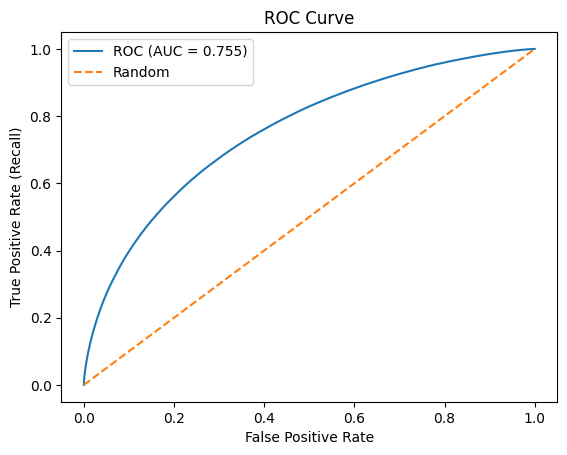

In [10]:
y_score = cb_cls.predict(X_test_cls, prediction_type='Probability')[:, 1]
y_score

fpr, tpr, thresholds = roc_curve(y_test_cls, y_score)
auc = roc_auc_score(y_test_cls, y_score)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:

y_pred_proba = cb_gpu_cls.predict(X_test_cls, prediction_type="Probability")
class_1_proba = y_pred_proba[:, 1]
y_test_binary = (y_test_cls == 1).astype(int)

for threshold in list(np.arange(0.4, 0.9, 0.02)):
    y_pred = (class_1_proba >= threshold).astype(int)
    precision = precision_score(y_test_binary, y_pred, zero_division=0)
    recall = recall_score(y_test_binary, y_pred, zero_division=0)
    f1 = f1_score(y_test_binary, y_pred, zero_division=0)
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Threshold: 0.40, Precision: 0.0979, Recall: 0.8154, F1: 0.1748
Threshold: 0.42, Precision: 0.1026, Recall: 0.7896, F1: 0.1816
Threshold: 0.44, Precision: 0.1077, Recall: 0.7623, F1: 0.1888
Threshold: 0.46, Precision: 0.1134, Recall: 0.7341, F1: 0.1964
Threshold: 0.48, Precision: 0.1193, Recall: 0.7039, F1: 0.2041
Threshold: 0.50, Precision: 0.1259, Recall: 0.6725, F1: 0.2120
Threshold: 0.52, Precision: 0.1330, Recall: 0.6404, F1: 0.2202
Threshold: 0.54, Precision: 0.1406, Recall: 0.6072, F1: 0.2283
Threshold: 0.56, Precision: 0.1488, Recall: 0.5729, F1: 0.2362
Threshold: 0.58, Precision: 0.1578, Recall: 0.5387, F1: 0.2441
Threshold: 0.60, Precision: 0.1673, Recall: 0.5035, F1: 0.2512
Threshold: 0.62, Precision: 0.1780, Recall: 0.4687, F1: 0.2580
Threshold: 0.64, Precision: 0.1893, Recall: 0.4327, F1: 0.2634
Threshold: 0.66, Precision: 0.2018, Recall: 0.3970, F1: 0.2676
Threshold: 0.68, Precision: 0.2153, Recall: 0.3612, F1: 0.2698
Threshold: 0.70, Precision: 0.2300, Recall: 0.3251, F1:

## Threshold Selection


We set the classification threshold to 0.54, which yields a recall of approximately 0.61 for the 1-hour delay class. This means that 61% of flights that are truly delayed by at least one hour are correctly identified by the model.

At this threshold, the precision is approximately 14%, indicating that when the model predicts a 1-hour delay, the prediction is correct 14% of the time. While this results in a higher number of false positives, this trade-off is intentional.


The objective of the model is early risk awareness rather than exact delay confirmation. In an operational setting, it is preferable to flag potential delays early, even at the cost of additional false alarms, than to miss a significant delay entirely. As such, getting higher recall aligns better with the intended use case of proactive delay awareness.


## Creating the new model

In [16]:
import numpy as np

class DelayClassifier:
    def __init__(self, model, threshold=0.6):
        self.model = model
        self.threshold = threshold

    def predict_proba(self, X):
        return self.model.predict(X, prediction_type="Probability")[:, 1]

    def predict(self, X):
        return (self.predict_proba(X) >= self.threshold).astype(int)

delay_classifier_final = DelayClassifier(cb_cls, threshold=0.54)

y_pred_cls = delay_classifier_final.predict(X_test_cls)

print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred_cls))
print(classification_report(y_test_cls, y_pred_cls))

Accuracy: 0.7543520847230578
Confusion matrix:
 [[4080501 1262402]
 [ 133635  206543]]
              precision    recall  f1-score   support

           0       0.97      0.76      0.85   5342903
           1       0.14      0.61      0.23    340178

    accuracy                           0.75   5683081
   macro avg       0.55      0.69      0.54   5683081
weighted avg       0.92      0.75      0.82   5683081



Note that the overall accuracy of the model is approximately 0.60. This is expected and acceptable for this task. Our goal is not to maximize accuracy, but rather to detect as many true delays as possible, particularly severe delays of one hour or more.

If we wanted to maximized accuracy, we can do this:

In [ ]:
import numpy as np

class DelayClassifier:
    def __init__(self, model, threshold=0.6):
        self.model = model
        self.threshold = threshold

    def predict_proba(self, X):
        return self.model.predict(X, prediction_type="Probability")[:, 1]

    def predict(self, X):
        return (self.predict_proba(X) >= self.threshold).astype(int)

delay_classifier_final_accuracy = DelayClassifier(cb_gpu_cls, threshold=1)

y_pred_cls = delay_classifier_final_accuracy.predict(X_test_cls)

print("Accuracy:", accuracy_score(y_test_cls, y_pred_cls))
print("Confusion matrix:\n", confusion_matrix(y_test_cls, y_pred_cls))
print(classification_report(y_test_cls, y_pred_cls))

Accuracy: 0.9401419758050255
Confusion matrix:
 [[5342903       0]
 [ 340178       0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97   5342903
           1       0.00      0.00      0.00    340178

    accuracy                           0.94   5683081
   macro avg       0.47      0.50      0.48   5683081
weighted avg       0.88      0.94      0.91   5683081



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Here, we made the model predect not delay for all data points, and got an accuracy of 94%. Because simply 94% of our data is not delayed. Now we can save our model and deploy it.

In [ ]:
import pickle
with open('./data/delay_classifier_final.pkl', 'wb') as f:
    pickle.dump(delay_classifier_final, f)

In [ ]:
import pickle
# read pickle file
with open('./data/catboost_full_model_v2.pkl', 'rb') as f:
    delay_classifier_loaded = pickle.load(f)

In [ ]:
from models.src.DelayClassifier import DelayClassifier
import joblib

delay_classifier = DelayClassifier(delay_classifier_loaded, threshold=0.54)
joblib.dump(delay_classifier, "models/delay_classifier_final.pkl")

['models/delay_classifier_final.pkl']

Let say we want to predict a flight that going from Baltimore to Denver on January 12 (in 6 days). We will need to call the FlightWeather class wrapper in order to get the weather and flight data.

In [ ]:
flightWeather = FlightWeather(flight_num="UA 2012", flight_date="2026-01-12")

In [ ]:
load_dotenv()

True

In [ ]:
flight_df = flightWeather.get_full_data()

In [ ]:
flight_df_engineered = FeatureEngineeringDepDelay(flight_df, type="new").engineer_features()

In [ ]:
BTW_DEN_pred_prob = delay_classifier_final.predict_proba(flight_df_engineered)

In [ ]:
BTW_DEN_pred = delay_classifier_final.predict(flight_df_engineered)

In [ ]:
display(BTW_DEN_pred, BTW_DEN_pred_prob)

array([0])

array([0.28485697])

The model predicts no high risk of a one-hour delay for this flight.
The estimated probability of a one-hour delay is approximately 28.5%, which is below the selected risk threshold of 0.44.

As a result, this flight is classified as low delay risk. While delays are still possible, the model does not flag this flight as requiring heightened awareness compared to higher-risk cases.

## Summary

In this notebook, an end-to-end machine learning pipeline was developed to model flight delay behavior using historical flight operations data enriched with engineered operational and weather features. The analysis demonstrated that predicting delays is inherently challenging due to high class imbalance, noisy real-world signals, and overlapping patterns between delayed and non-delayed flights.

Through experimentation with multiple modeling approaches, it became clear that accuracy alone is not a reliable metric for this problem. Models that achieved high accuracy often failed to identify delayed flights effectively. As a result, evaluation shifted toward recall, precision, F1-score, ROC-AUC, and balanced accuracy, which better reflect real operational risk.

Tree-based ensemble models showed improved performance over linear baselines, particularly when combined with class weighting, probability outputs, and decision-threshold tuning. Rather than treating the task as a strict binary decision, modeling delay risk as a probability proved more informative and practical for downstream use cases such as risk tiering, operational planning, or alerting systems.

Overall, this project highlights the importance of problem formulation, metric selection, and interpretability when working with large-scale, imbalanced datasets. While perfect prediction is not achievable given the stochastic nature of flight delays, the resulting models provide meaningful insights and a solid foundation for risk-aware decision support systems in aviation operations.